In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump, load
import tensorflow.lite as tf_lite # for saving a lightweight model

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    plot_confusion_matrix, confusion_matrix, roc_auc_score, make_scorer
)
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from skimage.feature import hog
from skimage.io import imread_collection
from skimage.color import rgb2gray
from skimage.transform import resize

from skopt import BayesSearchCV
from kerastuner import HyperModel, Hyperband

from imblearn.over_sampling import SMOTE

np.random.seed(42)

# Custom Transformers
Based on the work done in the eda notebook, custom transformers were created to be used in a pipeline.

In [2]:
class ResizeTransformer(BaseEstimator, TransformerMixin):
    '''This class is a TransformerMixIn which takes a shape parameter to resize images when using the transform method'''
    def __init__(self, shape=(128,128)):
        self.shape = shape
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array([resize(img, output_shape=self.shape) for img in X])
        return X

class GrayTransformer(BaseEstimator, TransformerMixin):
    '''This class is a TransformerMixIn which transforms images into grayscale'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        try:
            if X.shape[3] == 3:
                X = np.array([rgb2gray(img) for img in X])
            return X
        except: # to continue the pipeline if already in grayscale
            return X
        
class HogTransformer(BaseEstimator, TransformerMixin):
    '''This class is a TransformerMixIn with mirrored parameters from the skimage.feature hog function
    that takes an image and applies the hog function over it'''
    def __init__(self,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(4, 4),
    block_norm='L2-Hys',
    visualize=False,
    transform_sqrt=False,
    feature_vector=True,
    multichannel=None
    ):
        
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        self.visualize = visualize
        self.transform_sqrt = transform_sqrt
        self.feature_vector = feature_vector
        self.multichannel = multichannel

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array([hog(img,
                          orientations=self.orientations,
                          pixels_per_cell=self.pixels_per_cell,
                          cells_per_block=self.cells_per_block,
                          block_norm=self.block_norm,
                          visualize=self.visualize,
                          transform_sqrt=self.transform_sqrt,
                          feature_vector=self.feature_vector,
                          multichannel=self.multichannel           
        ) for img in X])
        return X

## Data Import
if running this on a slow computer, I would recommend setting conserve_memory=True.

In [3]:
glass = imread_collection('./images/glass/*', conserve_memory=False)
car = imread_collection('./images/car/*', conserve_memory=False)

X = np.concatenate((glass, car))

y = (np.zeros(len(glass)) + 1)
y = np.concatenate((y, np.zeros(len(car))))

#Clearing memory
glass = None
car = None

del glass
del car

## Preprocessing
In this section I am converting the images into grayscale, resizing them into 128 x 128, using SMOTE to oversample my underrepresented class for my train data, and finally calling the data in a keras ImageDataGenerator to randomly augment my dataset.

In [6]:
process = make_pipeline(GrayTransformer(), ResizeTransformer(shape=(128,128,1)))
X = process.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=.2)

#for streamlit demo
dump(X, '.streamlit/data/imgs.pkl', compress=9)
dump(y, '.streamlit/data/labels.pkl', compress=9)

Using SMOTE to oversample unbalanced classes for train data

In [7]:
X_train = X_train.reshape(X_train.shape[0], -1) #reshape for SMOTE

X_train, y_train = SMOTE(random_state=42).fit_sample(X_train, y_train)

X_train = X_train.reshape(X_train.shape[0], 128, 128, 1) #reshape back into image format

Clearing memory assignment

In [8]:
X = None
y = None

del X
del y

Setting up image data generators. The validation generator has fewer augmentations so that the resulting validation scores are more consistent. I didn't want deviations from the generator itself making it seem like progress hasn't been made.

In [9]:
train_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
).flow(x=X_train, y=y_train,seed=42)

validation_gen = ImageDataGenerator(
    horizontal_flip=True
).flow(x=X_test, y=y_test, seed=42)

## Support Vector Machine Method
For this method as the entire dataset needs to be fit upon at once, I created a function to aggregate the augmentations.

In [10]:
def generate_augmented_images(image_generator, num_batches = 100):
    
    X_, y_ = image_generator.next()
    
    for i in range(num_batches):
        batch = image_generator.next()
        X_temp, y_temp = (batch[0], batch[1])
        X_ = np.concatenate((X_, X_temp))
        y_ = np.concatenate((y_, y_temp))
        
    return (X_, y_)

X_train_svm, y_train_svm = generate_augmented_images(train_gen, 500)
X_test_svm, y_test_svm = generate_augmented_images(validation_gen, 20)

Setting up SVM pipeline

In [11]:
svm = Pipeline([
    ('hog', HogTransformer(orientations=12)),
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=256)),
    ('model', SVC())
],
verbose=1)

Setting up for hyperparameter tuning using Bayesian Optimization

In [12]:
scorer = make_scorer(roc_auc_score) # we care both about the true positive rate and the false positive rate

opt_params = {
    'hog__orientations':[i for i in range(1,32)],
    'hog__transform_sqrt':[True, False],
    'hog__block_norm': ['L2', 'L2-Hys'],
    'pca__n_components':[64,128,256],
    'model__gamma': ['scale', 'auto'],
    'model__C': [.01,.1,.25,.5,.75,1]
}

opt = BayesSearchCV(svm,
                   opt_params,
                   n_iter=30,
                   verbose=1,
                   cv=3,
                   random_state=42,
                   n_jobs=-1,
                   pre_dispatch='2*n_jobs',
                   scoring=scorer)

Searching for best hyperparameters. I cleared the output as it was very long.

In [ ]:
opt.fit(X_train_svm, y_train_svm)

The resulting metrics for my best SVM model actually surprised me. Later on when I manually configure a CNN, I could never actually get close to these scores for the validation data.

Best Parameters:  {'hog': HogTransformer(orientations=11, transform_sqrt=True), 'ss': StandardScaler(), 'pca': PCA(n_components=64), 'model': SVC()}
Test ROC-AUC Score:  0.9286115007012623
Train ROC-AUC score:  0.9402173913043479
Test Accuracy Score:  0.9265536723163842
Train Accuracy score:  0.9402173913043478
Support Vector Shape:  (5165, 64)


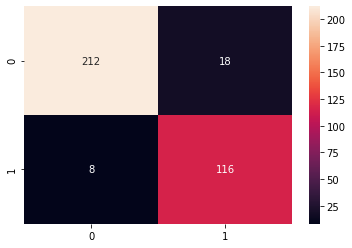

In [166]:
print('Best Parameters: ', opt.best_estimator_)
print('Test ROC-AUC Score: ', opt.score(X_test_svm, y_test_svm))
print('Train ROC-AUC Score: ', opt.score(X_train_svm, y_train_svm))
print('Test Accuracy Score: ', opt.best_estimator_.score(X_test_svm, y_test_svm))
print('Train Accuracy Score: ', opt.best_estimator_.score(X_train_svm, y_train_svm))
print('Support Vector Shape: ', opt.best_estimator_.named_steps['model'].support_vectors_.shape) # important for model size

confusion = confusion_matrix(y_test, opt.predict(X_test))
sns.heatmap(confusion, annot=True, fmt='g');

Saving best model

In [ ]:
dump(opt.best_estimator_, './Saved Models/svm.pkl', compress=1)

Removing unneeded variables from memory

In [23]:
X_train_svm = None
X_test_svm = None

y_train_svm = None
y_test_svm = None

del X_train_svm
del X_test_svm

del y_train_svm
del y_test_svm

Testing saved model

In [161]:
saved_model = load('./Saved Models/svm.pkl') # testing saved model
print(saved_model.score(X_test, y_test))
saved_model = None

0.9265536723163842


## Convolutional Neural Network Method
In this section I manually tuned a convolutional network to explore: the optimal number of layers, activation function types, whether or not to use batchnormalization, whether or not to use drop, and learning rates.

In [167]:
model = Sequential()

Output was cleared to allow for reading in github

In [ ]:
model.add(Input((128,128,1)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=.000001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'AUC'])

stop = EarlyStopping(monitor='loss', patience=50)

batch_size = 64
epochs = 5_000

history = model.fit(train_gen,
                        batch_size=batch_size,
                        validation_data=validation_gen,
                        validation_steps=validation_gen.x.shape[0]/batch_size,
                        steps_per_epoch=train_gen.x.shape[0]/batch_size,
                        epochs=epochs,
                        callbacks=stop,
                        verbose=2)

In [169]:
val_scores = model.evaluate(X_test, y_test)

12/12 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8750 - auc: 0.92 - ETA: 0s - loss: 0.3347 - accuracy: 0.8636 - auc: 0.93 - 0s 5ms/step - loss: 0.3332 - accuracy: 0.8644 - auc: 0.9382


The accuracy of 86% and roc auc of .94 is fairly decent. There seems to be more false positives than false negatives.

Validation scores:  [0.3332103490829468, 0.8644067645072937, 0.9381662011146545]


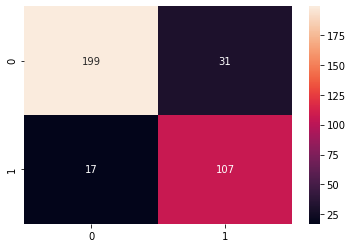

In [170]:
print('Validation scores: ', val_scores)
confusion = confusion_matrix(y_test, np.round(model.predict(X_test)).reshape(-1))
sns.heatmap(confusion, annot=True, fmt='g');

One issue in looking at the different metrics is that each time I train the model it sees different images unless I restart the kernel. I tried to overcome this issue with a low learning rate, but it still happens to some degree. I ended up adding layers until accuracy wouldn't increase anymore and there was only a moderate overfit.

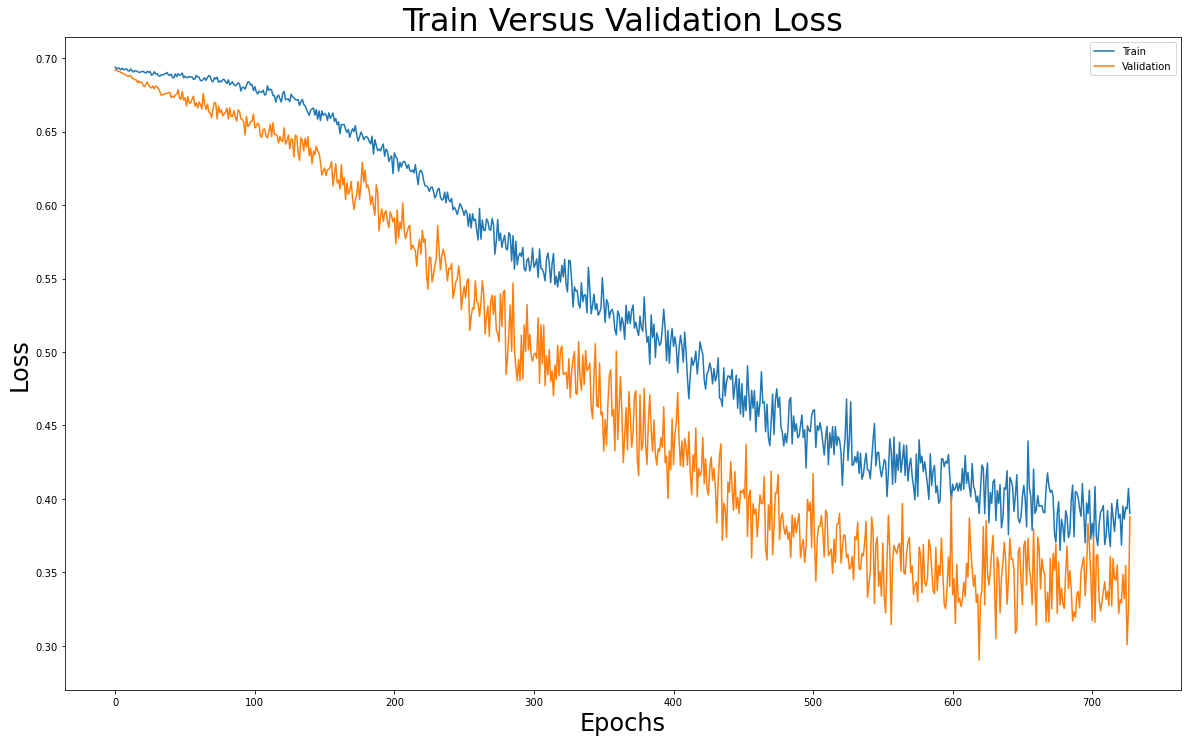

In [171]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.legend(['Train', 'Validation']);
plt.xlabel('Epochs', fontdict={'fontsize':24});
plt.ylabel('Loss', fontdict={'fontsize':24});
plt.title('Train Versus Validation Loss', fontdict={'fontsize':32});

Saving model as a tflite file

In [172]:
def save_keras_model(model, filename):

    converter = tf_lite.TFLiteConverter.from_keras_model(model)

    lite_model = converter.convert()

    with open(f'./Saved Models/{filename}.tflite', 'wb') as f:
        f.write(lite_model)

    model_loaded = tf_lite.Interpreter(model_path=f'./Saved Models/{filename}.tflite')

In [ ]:
save_keras_model(model, 'cnn')

## Fine Tuning CNN

Using what I explored in the above model, I wanted to try out numerous configurations for my CNN that would take a long time to do manually. In this section I took the above connfiguration and adding min/max values for hyperparameter searching. Hyperbanding was the technique used. It is something that tests a variety of configurations, compares them to one another and picks half to continue training. This keeps going until it finds what it thinks is the optimal model.

In [16]:
filters_min = 32
filters_max = 256
pool_min = 2
pool_max = 4
kernel_min = 3
kernel_max = 9


class CNN_HyperModel(HyperModel):
    '''This class contains the configurations to test the cnn model with for this project.'''
    def build(self, hp):
        
        model = Sequential()
        
        model.add(Input((128,128,1)))
        
        model.add(Conv2D(filters=hp.Int('filters1', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels1', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=hp.Int('pool1', min_value=pool_min, max_value=pool_max, step=1)))
        
        model.add(Conv2D(filters=hp.Int('filters2', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels2', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(Conv2D(filters=hp.Int('filters3', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels3', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=hp.Int('pool2', min_value=pool_min, max_value=pool_max, step=1)))
        
        model.add(Conv2D(filters=hp.Int('filters4', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels4', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(Conv2D(filters=hp.Int('filters5', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels5', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(Conv2D(filters=hp.Int('filters6', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels6', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=hp.Int('pool3', min_value=pool_min, max_value=pool_max, step=1)))
        
        model.add(Flatten())
        
        model.add(Dense(hp.Int('dense1', min_value=64, max_value=512, step=64), activation='relu'))
        model.add(Dropout(hp.Float('dropout1', min_value=0, max_value=.5, step=.1)))

        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Float('adam1',
            min_value=1e-6, max_value=1e-2, sampling='LOG')), metrics=['accuracy', 'AUC'])
        
        return model

In [17]:
hypermodel = CNN_HyperModel()

hyperband = Hyperband(hypermodel, objective='loss', max_epochs=200, seed=42)

**Warning** to run the below will take up around 15GB of space and can take hours to run even on an nvidia graphics card. The output was cleared to be able to load in github.

In [ ]:
hyperband.search(x = train_gen, verbose=0)

In [138]:
model = hyperband.get_best_models(num_models=1)[0]

The below is the best CNN configuration chosen by the optimization.

In [99]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 224)       129248    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       258176    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 96)        602208    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 160)       1

In [158]:
val_scores = model.evaluate(validation_gen)

12/12 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.9375 - auc: 0.96 - ETA: 0s - loss: 0.4607 - accuracy: 0.9531 - auc: 0.97 - ETA: 0s - loss: 0.3810 - accuracy: 0.9602 - auc: 0.98 - 0s 10ms/step - loss: 0.3788 - accuracy: 0.9605 - auc: 0.9824


The below shows that the model selected is by far and away better than all of the previous models in both accuracy and roc auc.

Validation loss: [0.37883710861206055, 0.9604519605636597, 0.9824333786964417]


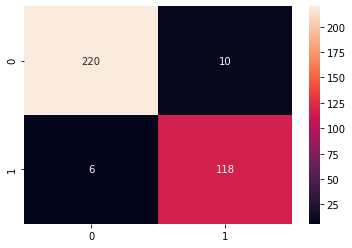

In [159]:
print(f'Validation loss: {val_scores}')
confusion = confusion_matrix(y_test, np.round(model.predict(X_test)).reshape(-1))
sns.heatmap(confusion, annot=True, fmt='g');

In [ ]:
save_keras_model(model, 'tuned_cnn')

Testing to make sure my saved model works

In [180]:
model_loaded = tf_lite.Interpreter(model_path="./Saved Models/tuned_cnn.tflite")

input_details = model_loaded.get_input_details()
output_details = model_loaded.get_output_details()

model_loaded.resize_tensor_input(input_details[0]['index'], (32, 128, 128, 1))
model_loaded.resize_tensor_input(output_details[0]['index'], (32, 1))
model_loaded.allocate_tensors()

val_batch, val_label = validation_gen.next()
model_loaded.set_tensor(input_details[0]['index'], val_batch)
model_loaded.invoke()

model_preds = model_loaded.get_tensor(output_details[0]['index'])
print("Prediction results shape:", model_preds.shape)
print('ROC AUC Score: ', roc_auc_score(val_label, model_preds))

Prediction results shape: (32, 1)
ROC AUC Score:  0.9954545454545455
